## @ Author 3X Statistics Group

#### Topic - The Fascinating Differences In The Way We Use Our Phone

* Link to survey is [here](https://goo.gl/forms/ir7SynvdZBPnRtWI2)
* Complete project sits [here](https://github.com/mmd52/3XStatistics)

#### Group Members

1. Mohammed Topiwalla
2. Abraham Chandy
3. Patricia Londono
4. Fernanda De Oliveira Guimaraes
5. Hani Nabulsi

***Business Problem*** 
* We have ratings from multiple customers about what they look in a phone before buying a new one
* We want to help the Business by enabling them to target the right group of customers for their new phone launches and to help them understand what their customers want

* After obtaining the data Cleaning was performed in ***python*** the code for it is [here](https://github.com/mmd52/3XStatistics/blob/master/PythonArea/DataCleaning_3XStats.ipynb)
* Additional data rearrangement was done [here](https://github.com/mmd52/3XStatistics/blob/master/PythonArea/DataRearrangement_3XStats.ipynb)
* The data consumed by these python scripts is [this](https://github.com/mmd52/3XStatistics/blob/master/DATA/EnglishData.csv). The data thrown out from the scripts is [here](https://github.com/mmd52/3XStatistics/blob/master/DATA/data_e.csv)

In [1]:
*Set Path;
%let path=/folders/myfolders/MDS/SAS/3XStatistics/;
libname stat "/folders/myfolders/MDS/SAS/3XStatistics/";

*Load and Store data in workspace;
proc import datafile = '/folders/myfolders/MDS/SAS/3XStatistics/data_e.csv'
out = stat.data
dbms = csv
replace;
run;

SAS Connection established. Subprocess id is 4916



In [2]:
*Exploring data;
proc means data=stat.data n nmiss min max range mean median mode var std;
run;

Variable,N,N Miss,Minimum,Maximum,Range,Mean,Median,Mode,Variance,Std Dev
Brand Color CameraQuality BatteryLife OS Price ValueForMoney Recom_Frnd_Fly Trends PromotionsAvailable PhoneDistraction Id,110 110 110 110 110 110 110 110 110 110 110 110,0 0 0 0 0 0 0 0 0 0 0 0,1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000,10.0000000 10.0000000 10.0000000 10.0000000 10.0000000 10.0000000 10.0000000 10.0000000 10.0000000 10.0000000 10.0000000 110.0000000,9.0000000 9.0000000 9.0000000 9.0000000 9.0000000 9.0000000 9.0000000 9.0000000 9.0000000 9.0000000 9.0000000 109.0000000,4.6000000 4.0272727 4.8818182 5.0090909 5.0545455 4.7545455 4.7363636 4.2454545 3.8272727 4.4909091 6.5363636 55.5000000,4.0000000 3.0000000 4.5000000 5.0000000 5.0000000 5.0000000 4.5000000 3.0000000 3.0000000 3.0000000 7.0000000 55.5000000,1.0000000 2.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 2.0000000 2.0000000 1.0000000 7.0000000 .,10.3706422 8.8891576 12.3804003 13.7522102 13.9603003 11.8015847 12.6546289 8.1869058 7.7772310 10.3072560 5.5904087 1017.50,3.2203481 2.9814690 3.5185793 3.7083973 3.7363485 3.4353435 3.5573345 2.8612769 2.7887687 3.2104916 2.3644045 31.8982758


##### Creating a correlation plot to see how interdependant our variables are

In [3]:
proc corr data= stat.data;
var Brand Color CameraQuality BatteryLife OS Price ValueForMoney Recom_Frnd_Fly Trends PromotionsAvailable ;
run;

From the above results its visible that
* All our correlation data is positive
* They all are nearly going towards one
* This is a sign of perception bias
* To verify our results performing PCA


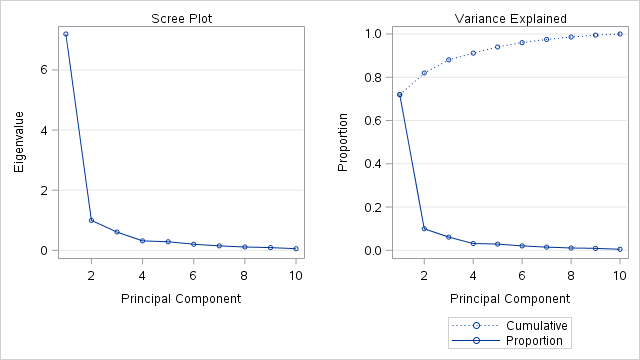

In [4]:
proc princomp data=stat.data out=stat.prinCompData;
var Brand Color CameraQuality BatteryLife OS Price ValueForMoney Recom_Frnd_Fly Trends PromotionsAvailable ;
run;
* From the scree and variablity plot we conclude that 4 components can explain 90% of the variance;

Ok so from the PCA we know this
* The First Component is able to explain 70 % of the variation (A bit strange)
* First component has all positive values looks like that could be a problem

In [5]:
*Genrating averages;
data stat.data_avgAdd;
set stat.prinCompData;
avg_i=mean(of Brand Color CameraQuality BatteryLife OS Price ValueForMoney Recom_Frnd_Fly Trends PromotionsAvailable);
run;

In [6]:
*Checking correlation;
proc corr data=stat.data_avgAdd;
var prin1 avg_i;
run;

##### From the PCA and correlation output it is visible that our data has a perception bias and we need to eliminate this , by standardising it

In [7]:
*Since the output is super close to one we will standardize;

data stat.data_std;
set stat.data;
avg=mean(of Brand Color CameraQuality BatteryLife OS Price ValueForMoney Recom_Frnd_Fly Trends PromotionsAvailable);
minimum=min(of Brand Color CameraQuality BatteryLife OS Price ValueForMoney Recom_Frnd_Fly Trends PromotionsAvailable);
maximum=max(of Brand Color CameraQuality BatteryLife OS Price ValueForMoney Recom_Frnd_Fly Trends PromotionsAvailable);
array in Brand Color CameraQuality BatteryLife OS Price ValueForMoney Recom_Frnd_Fly Trends PromotionsAvailable;
array output new1-new10;
do over output;
output=.;
if in>avg then output =((in-avg)/(maximum-avg));
if in<avg then output =((in-avg)/(avg-minimum));
if in=. then output=0;
if minimum = maximum then output=0;
if in= avg then output=0;
end;
run;


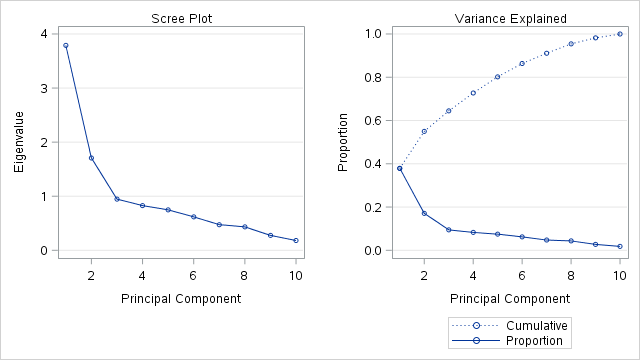

In [8]:
proc princomp data=stat.data_std out=stat.prinCompData_std;
var new1-new10 ;
run;
*The results are awesome We had a big dam perception bias;

##### Now if we observe the first component is explaining only roughly 40% of the bias, that means we have been able to get rid of the perception bias and our data is finally ready for clustering
* Now the first 4 components can explain roughly 70% of the variation which should be doable
* Now we have standardised data as well as PCA components, lets try doing clustering on both of them , well evaluate which one is better

###### Wards Minimum Variance Method

  - This method has one goal to minimize total variance within a cluster
  - Initially each data point is a cluster on its own.
  - The criterion for merging the cluster is based on an optimal value of an objective function.
  - The objective value is mostly *SSE* (Sum of Squares Error)


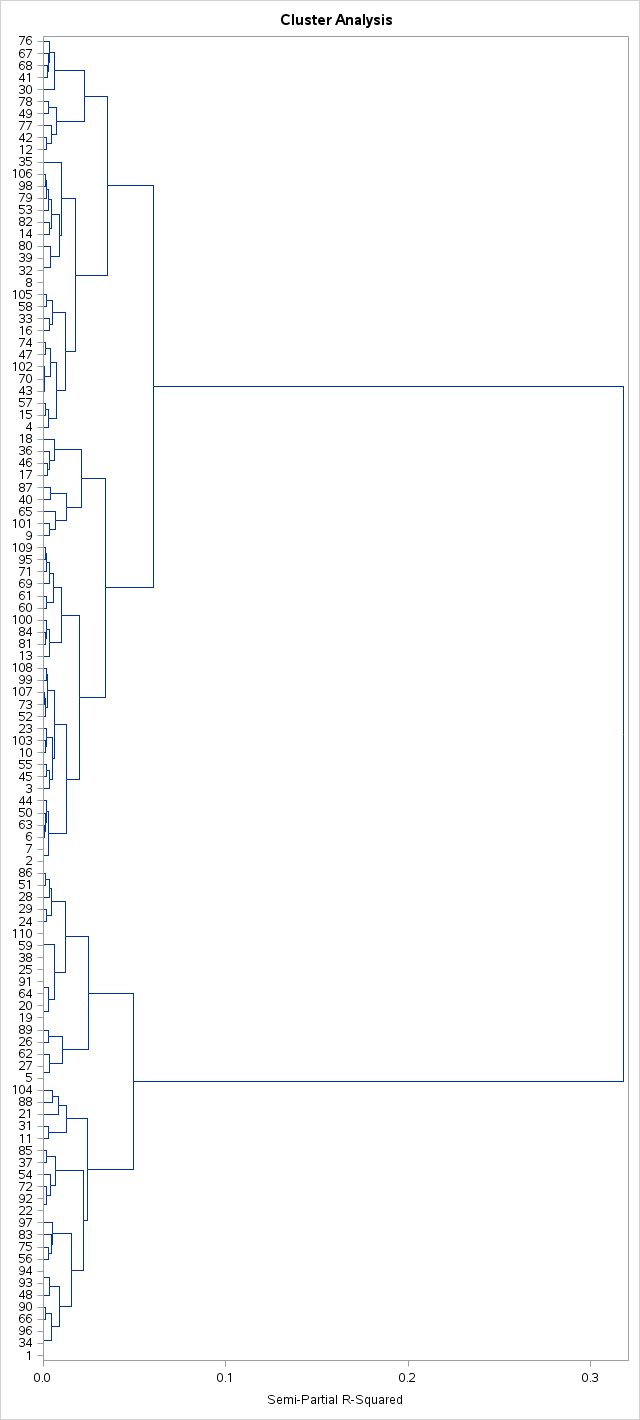

In [9]:
*Ok now trying out Ward method clustering on the Standardised variables;
proc cluster data=stat.prinCompData_std method=ward;
var new1-new10;
id Id;
run;
*The Ward methods dendogram is better;
*Root-Mean-Square Total-Sample Standard Deviation	0.854051;
*Root-Mean-Square Distance Between Observations	3.819431;


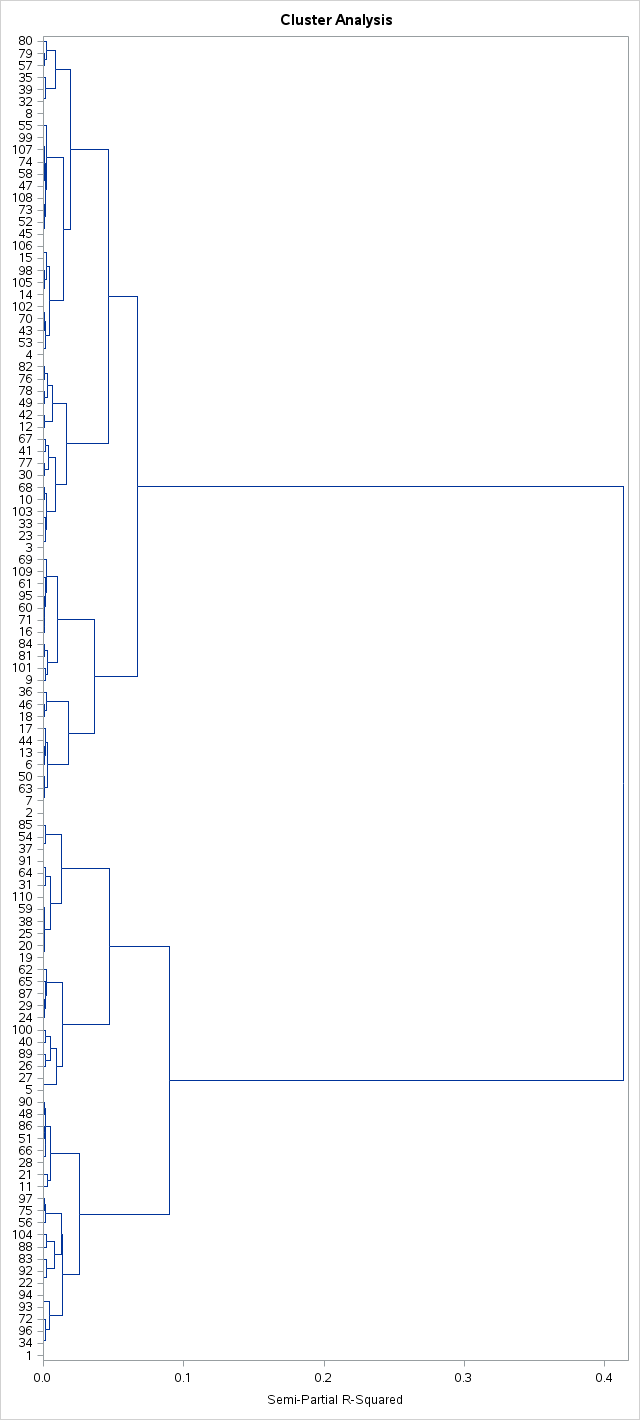

In [10]:
*Ok now trying out Ward method clustering on the principal components;
proc cluster data=stat.prinCompData_std method=ward;
var prin1-prin4;
id Id;
run;

#### From the Dendograms its seems like the clustering on the 4 components was more effective

In [11]:
proc tree ncl=4 out=stat.cluster noprint;
id id;
run;
*The Ward methods dendogram is better;
*Root-Mean-Square Total-Sample Standard Deviation	1.348167;
*Root-Mean-Square Distance Between Observations	3.813191;

#### 4 Clusters are a perfect number as with 5 clusters the size of our clusters get to small

In [12]:
*I am now joining my clustering result as a categorical variable to my original data set;

proc sort data=stat.prinCompData_std; by id; run;
proc sort data=stat.Cluster; by id ; run;

data stat.final;
merge stat.prinCompData_std stat.Cluster;
by id;
run;

In [13]:
*Analyze the clustering;
proc freq data=stat.final;
table cluster;
run;

CLUSTER,Frequency,Percent,CumulativeFrequency,CumulativePercent
1,22,20.00,22,20.00
2,23,20.91,45,40.91
3,43,39.09,88,80.00
4,22,20.00,110,100.00


#### Ok now that I have my clusters, let me characterize and understnd why mu clusters exists. We could do this with the help of comparing our cluster with the entire population

In [15]:
*Combining the population with clustering reults. Since I have 4 clusters my population is cluster 5;
data stat.data_population;
set stat.final;
cluster=5;
run;


data stat.pop_cluster_data;
set stat.final stat.data_population;
run;

In [16]:
*Analyze the clustering with the population;
proc freq data=stat.pop_cluster_data;
table cluster;
run;
* Perfection now we need to comapre our clusters with the population and see what makes them unique;

CLUSTER,Frequency,Percent,CumulativeFrequency,CumulativePercent
1,22,10.00,22,10.00
2,23,10.45,45,20.45
3,43,19.55,88,40.00
4,22,10.00,110,50.00
5,110,50.00,220,100.00


Now that All the data is here, this is what we need to do
1. We need to check which variables have a positive or negative effect in that clustering
2. So we compare each cluster with the population cluster
3. Ok to do this we will run a T-Test

****T-Test**** what to check for
1. First check if the variances are equal by seeing the pooled f tests. If the probability is significant we are dealing with unequal variances
2. Next we check for normal distribution seeing the normal plots and qq plots
3. Once thats done its time to see if the equal or unequal tests based on what you deduced from step 1 is significant or not.
4. If they are significant check for the difference in mean
5. If this is positive the variable is something important that people in our cluster consider and if negative it has a negative impact for individuals in our cluster


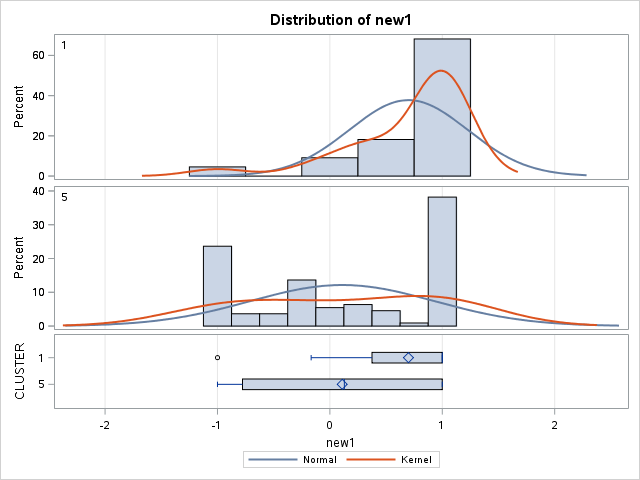
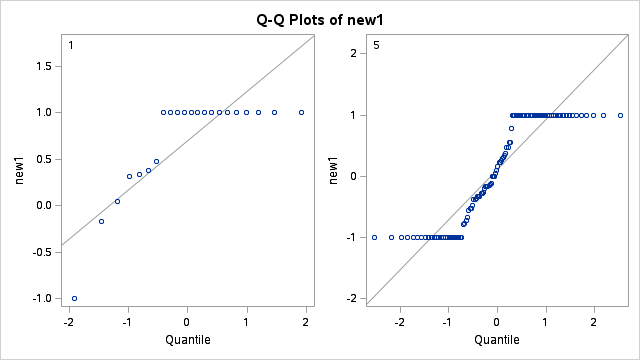
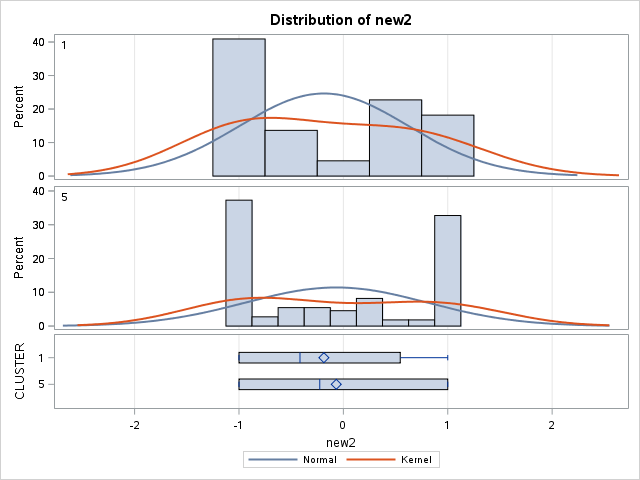
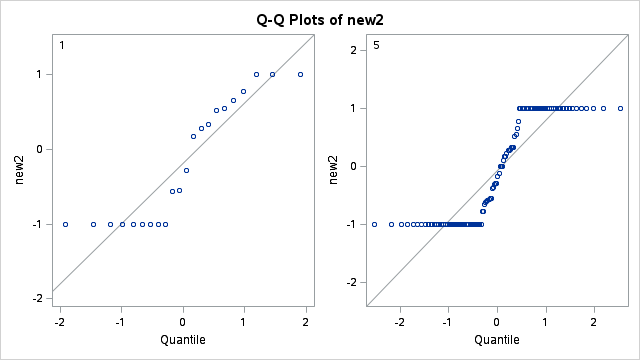
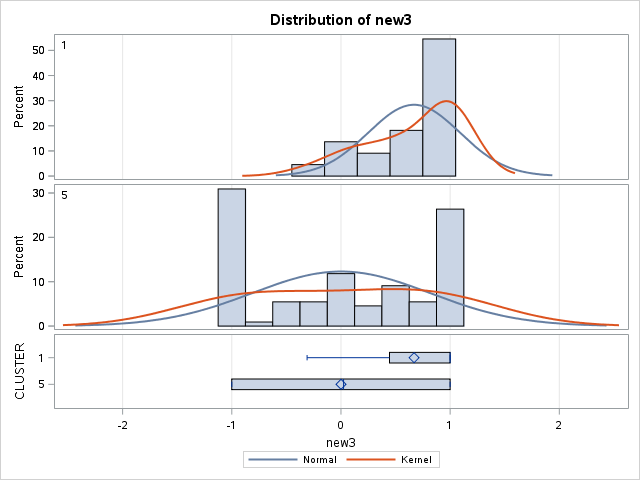
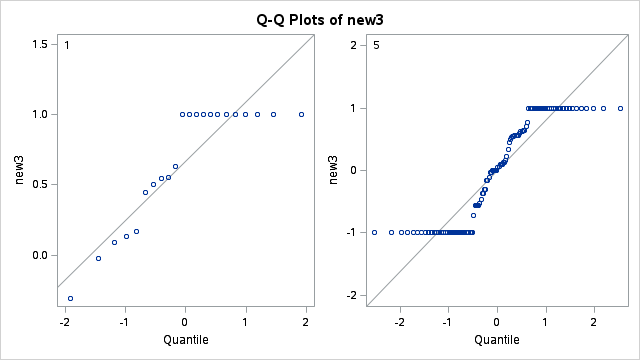
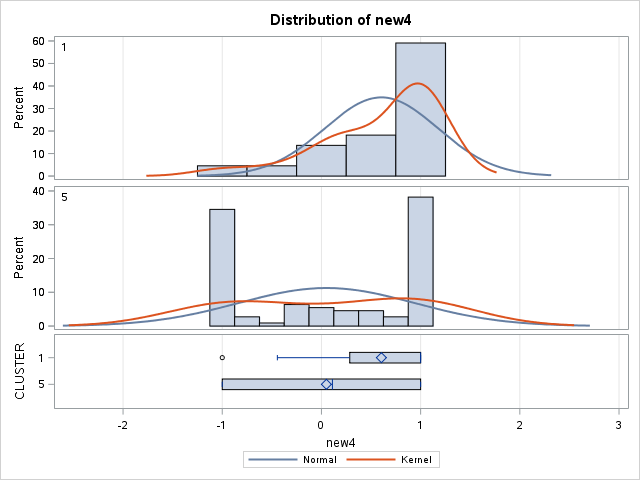
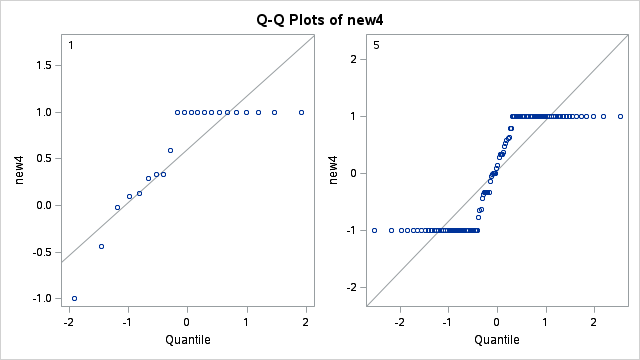
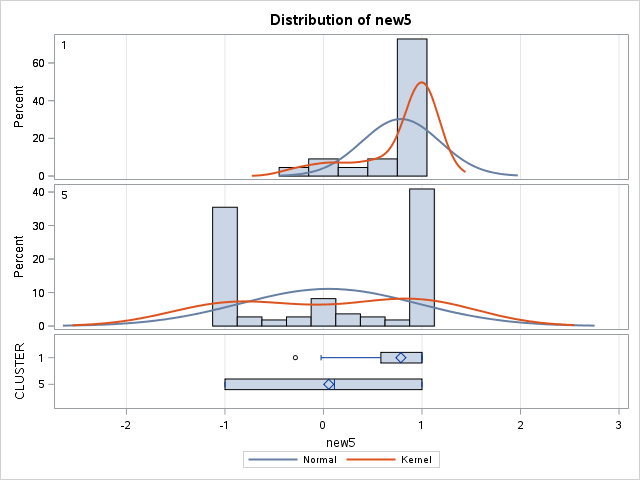
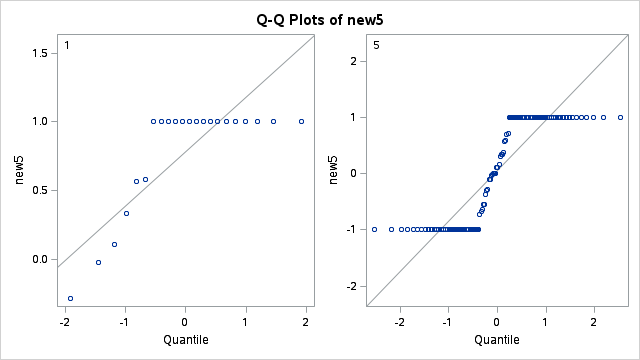
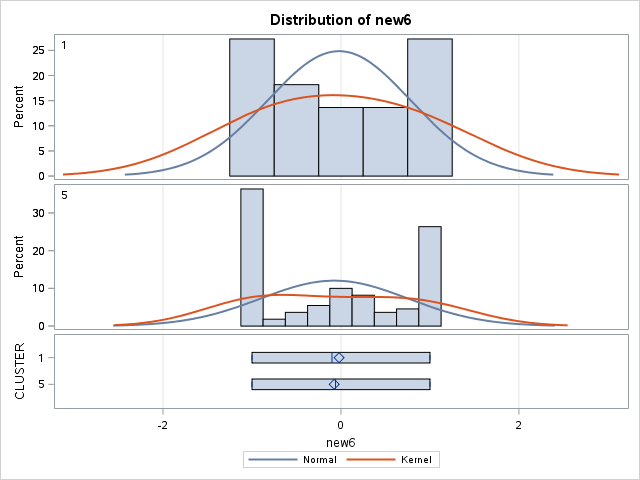
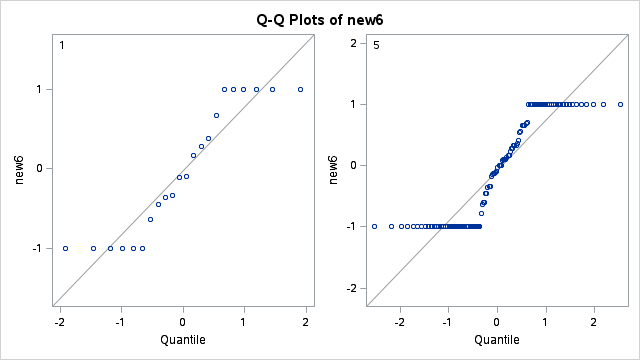
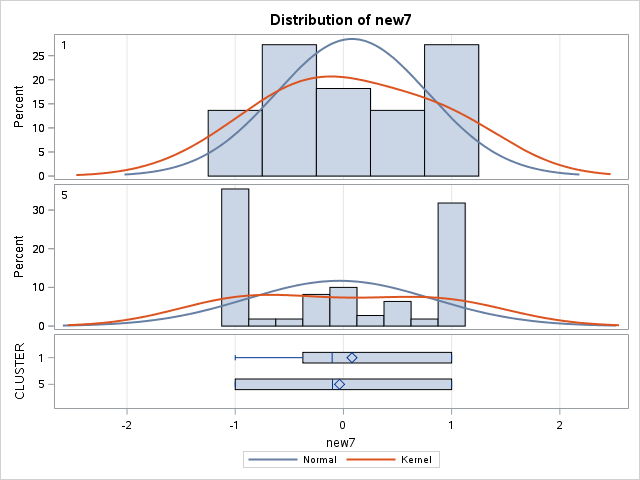
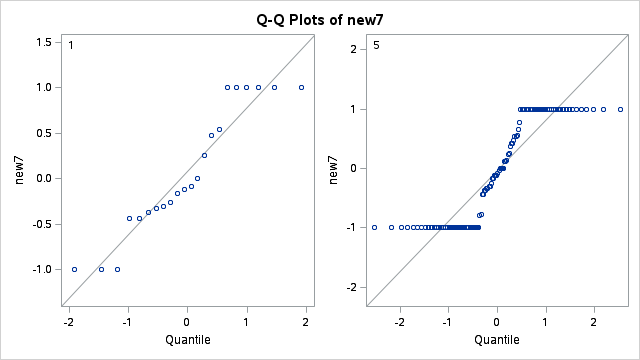
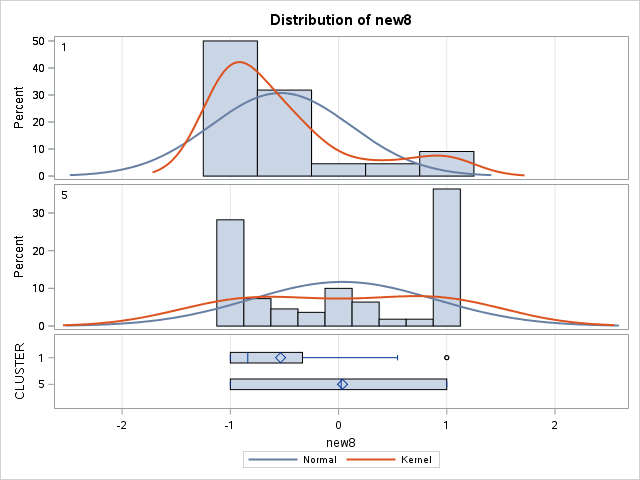
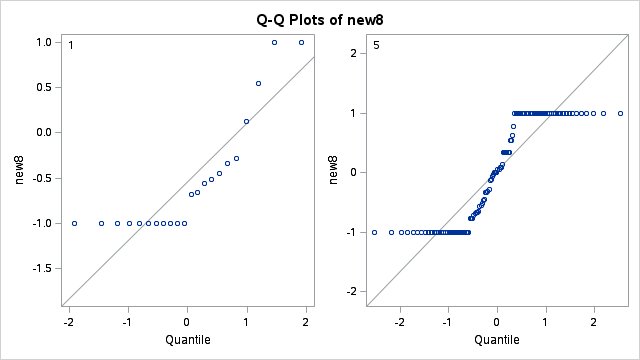
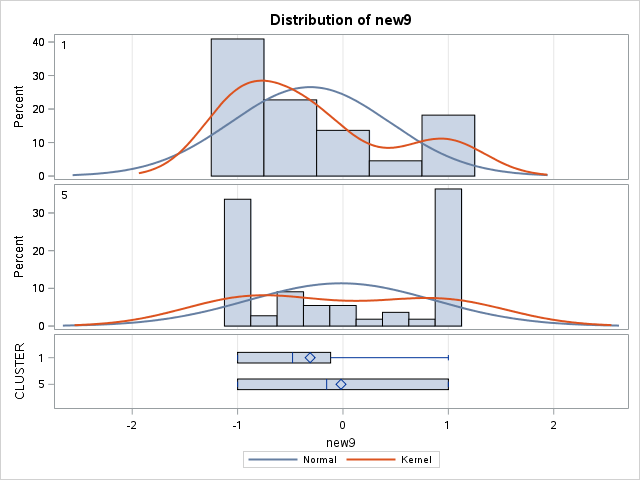
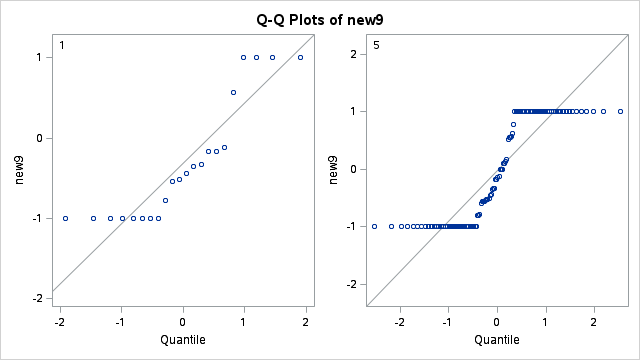
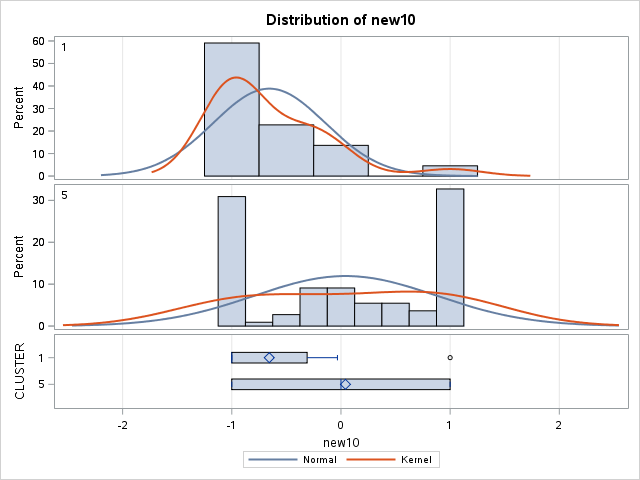
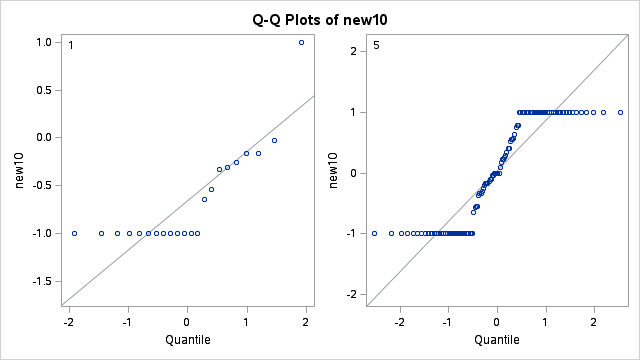

In [19]:
* For cluster 1;
proc ttest data=stat.pop_cluster_data;
var new1-new10;
where cluster=1 or cluster=5;
class cluster;
ods output ttests=stat.ttest_1;
run;

##### Interpretation for Cluster 1
Variables that cannot exaplain cluster 1 Individuals
1. Color
2. Price
3. Value for money
4. Trends


However For individuals in Cluster 1

1. OS is the most important thing in a phone
2. Camera Quality is the second most important thing
3. Brand is the 3rd most important
4. Battery life is the 4 th most important thing
5. Individuals in Cluster1 never consider promotions and recommendations while buying a new phone

****Actual BreakUp****

* Important Variables
* OS 										  0.7321 
* Camera Quality 							  0.6693 
* Brand 									  0.5891 
* Battery Life 							      0.5539 
* Promotions available 					     -0.698 
* Recommendations from friends and family    -0.5725

****Because Brand is important cluster 1 has the most number of iphones****

****Cluster 1 also comprises mainly of 26-45 years age group individuals****


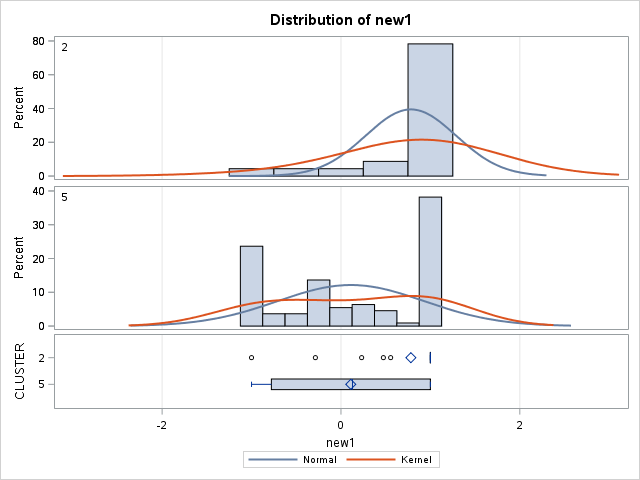
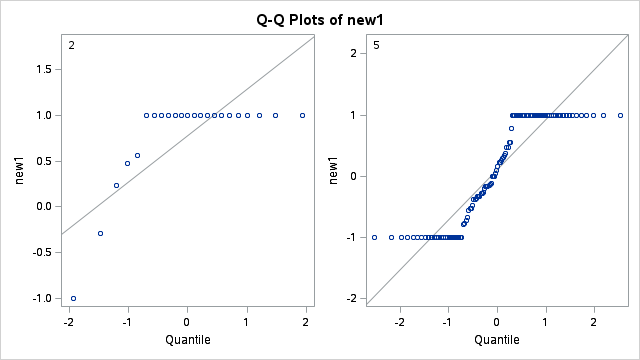
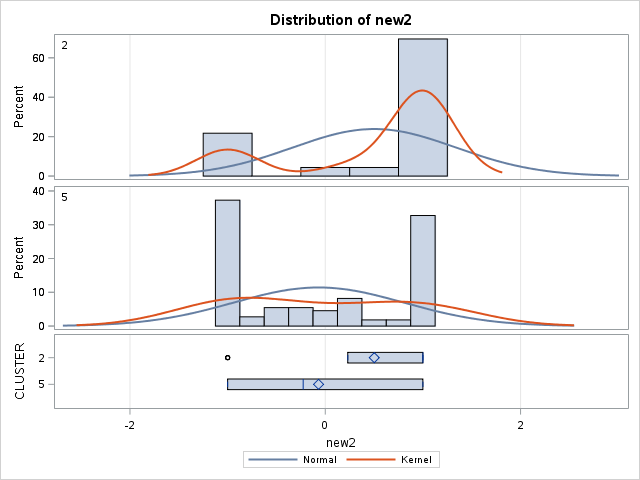
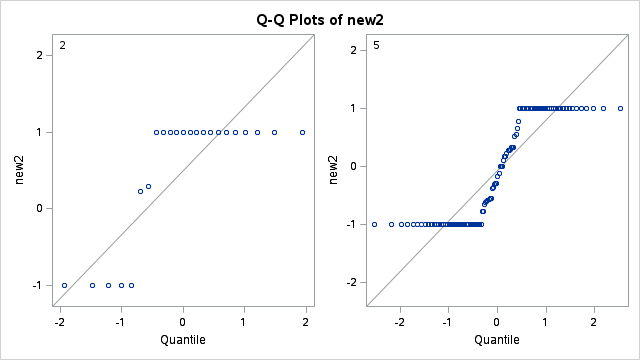
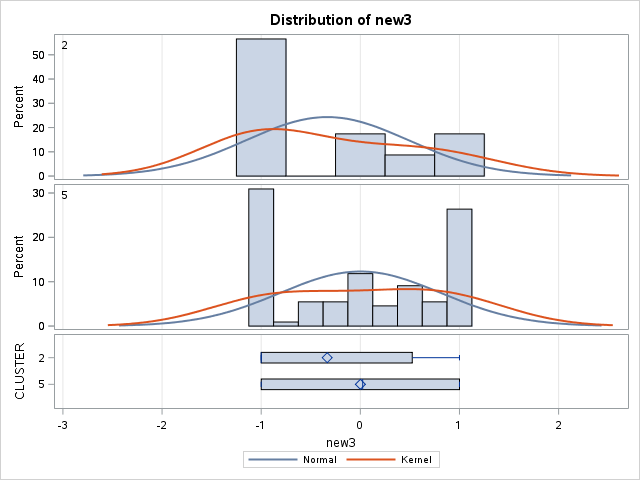
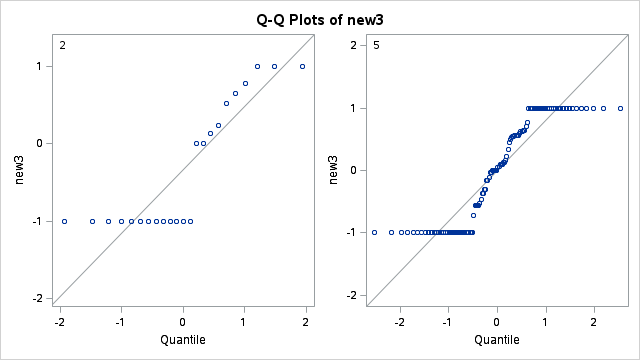
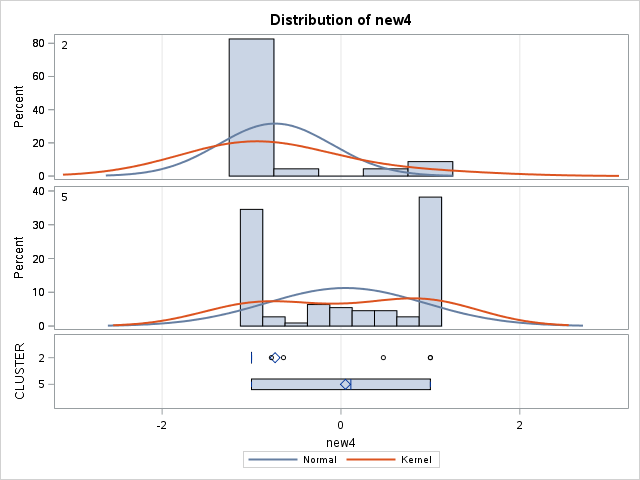
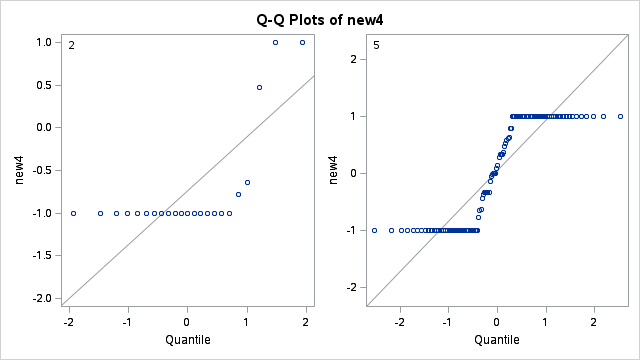
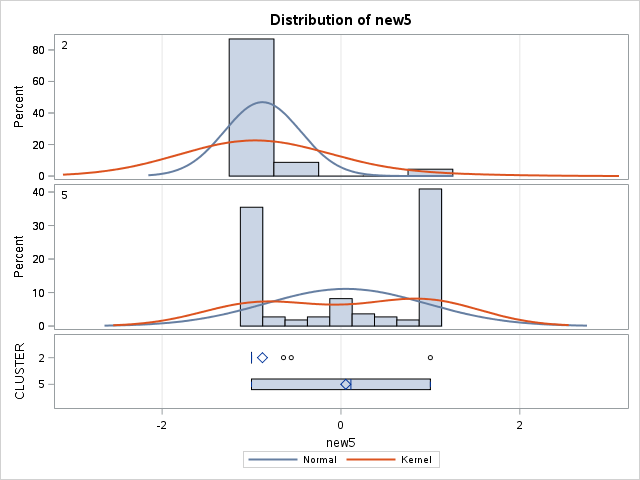
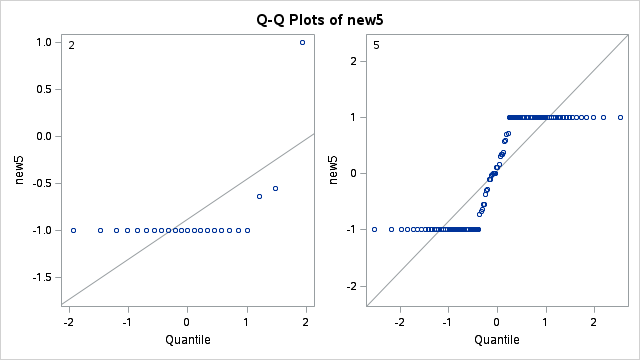
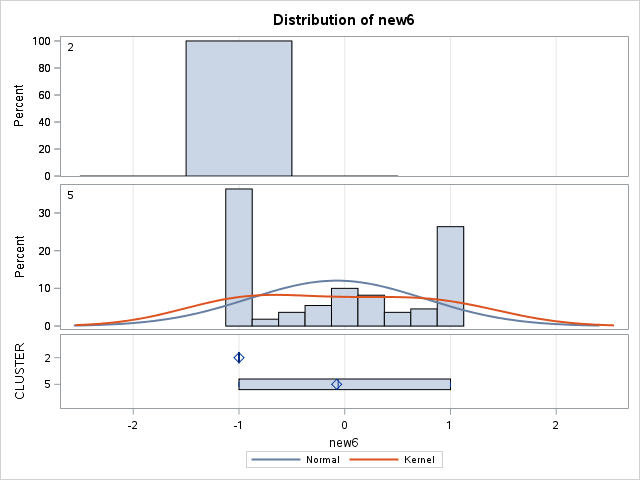
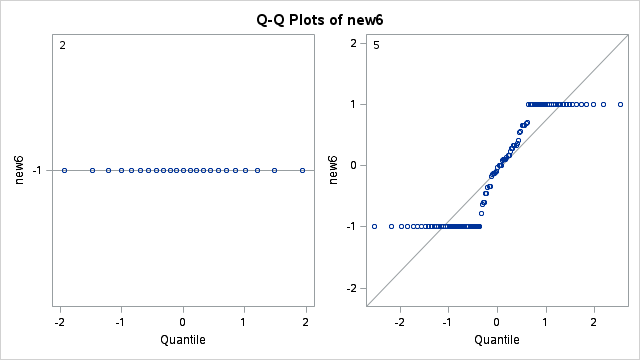
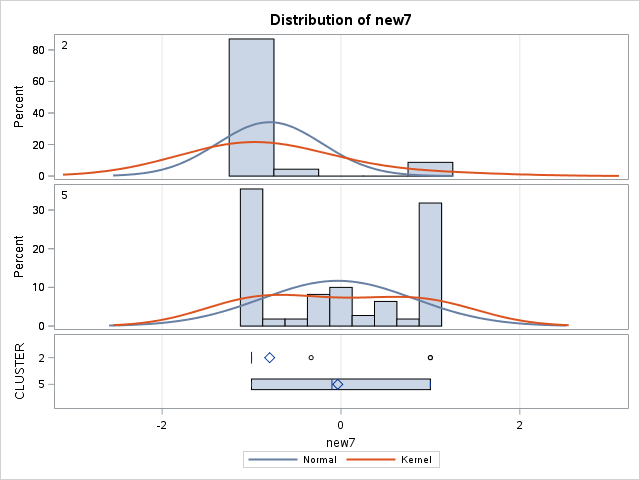
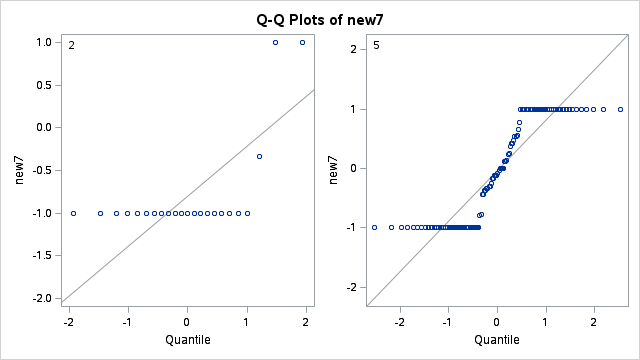
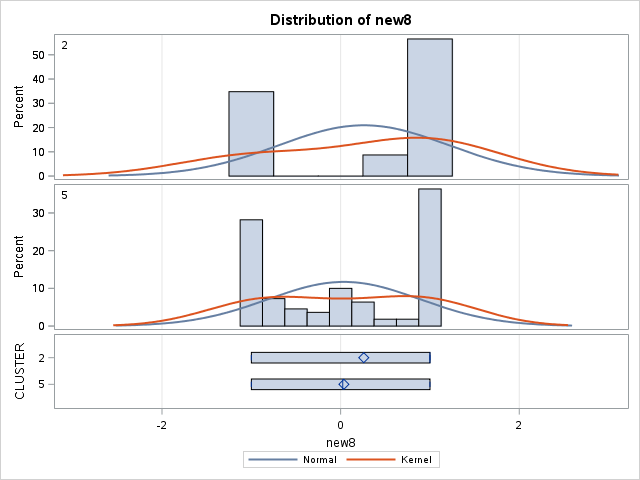
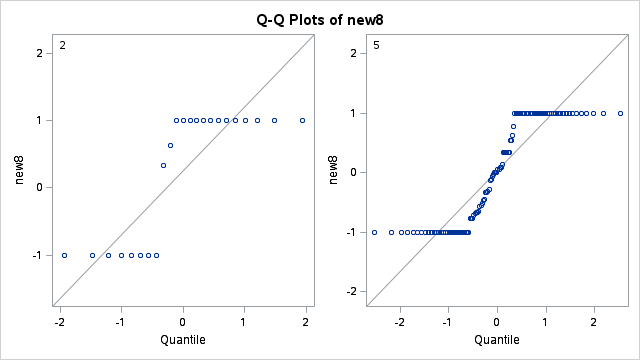
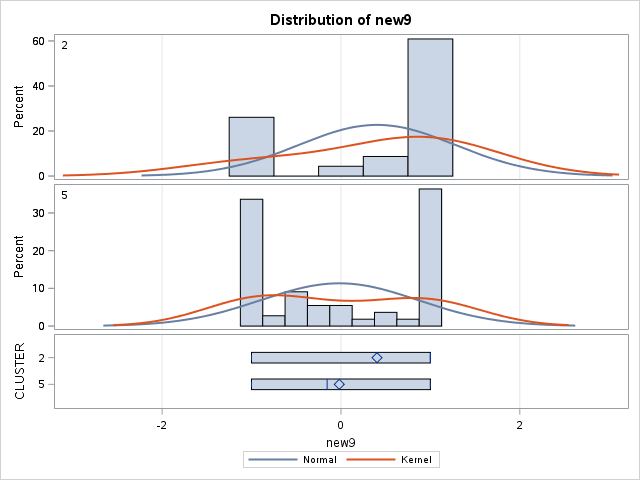
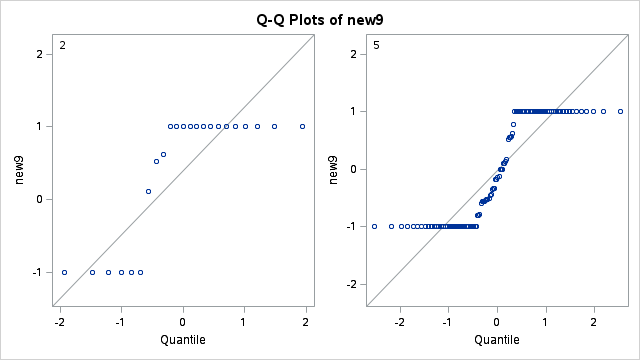
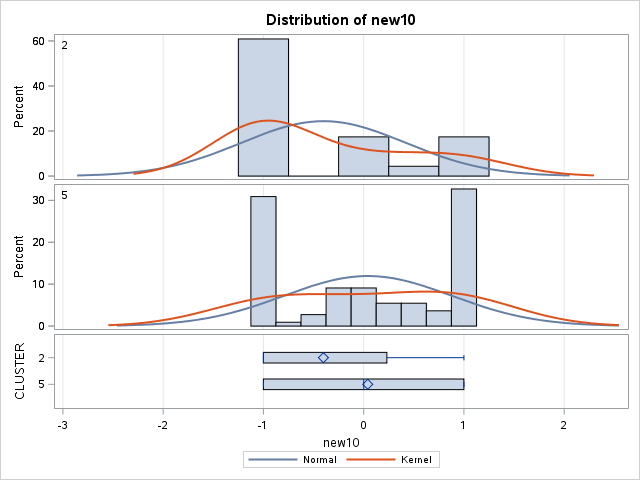
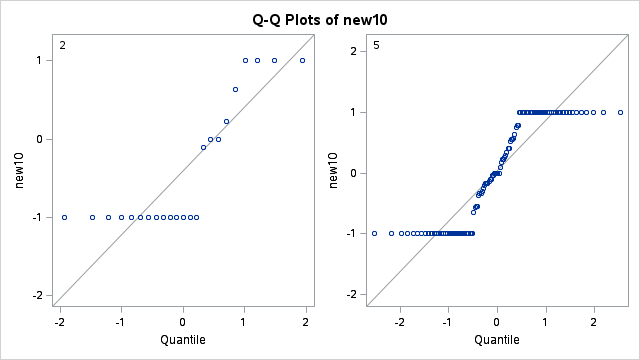

In [20]:
* For cluster 2;
proc ttest data=stat.pop_cluster_data;
var new1-new10;
where cluster=2 or cluster=5;
class cluster;
ods output ttests=stat.ttest_2;
run;

##### Interpretation for Cluster 2
Variables that cannot explain Cluster 2 Individuals
1. Camera Quality
2. Reccomendations from Friends and Family


However for individuals in Cluster 2

1. Brand , Color and Trends of a phone is an important characteristic for these individuals
2. Individuals in cluster 2 are not concerned with Price and OS of a phone when buying a new one
3. Battery Life, Value for money and Promotions available also is something not considered by individuals of this cluster

****Actual BreakUp****

* Important Variables
* Brand   0.6718
* Color   0.5698
* Trends   0.4219
* Price  -0.9239
* OS  -0.9317
* Battery Life  -0.7869
* Value For money  -0.7611
* Promotions available -0.4431


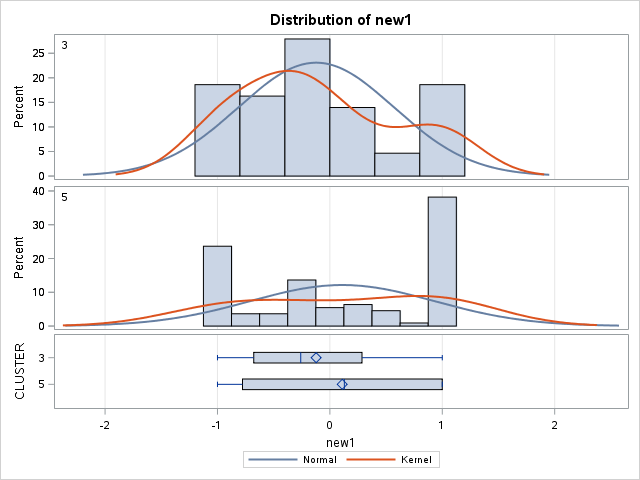
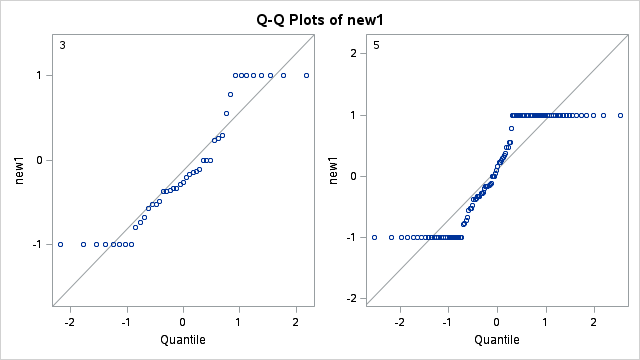
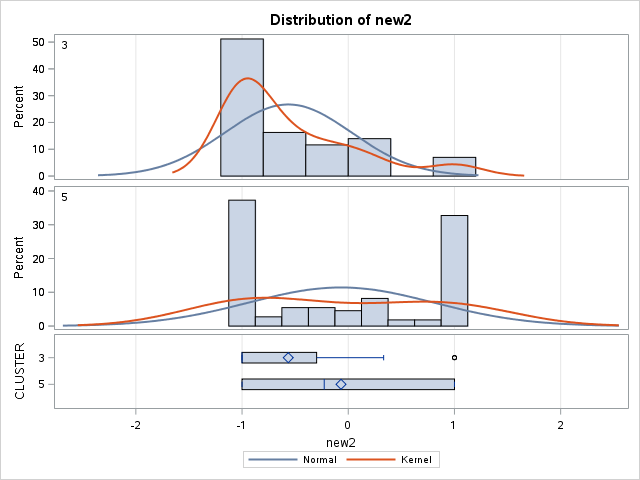
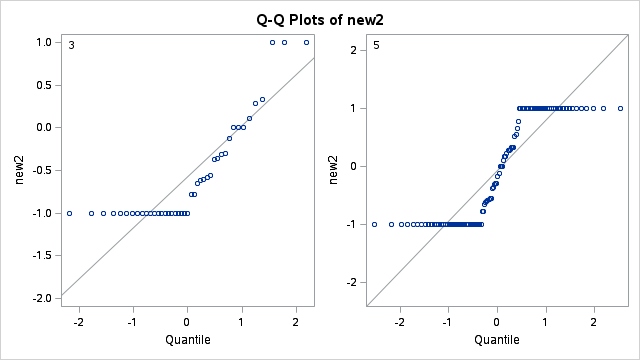
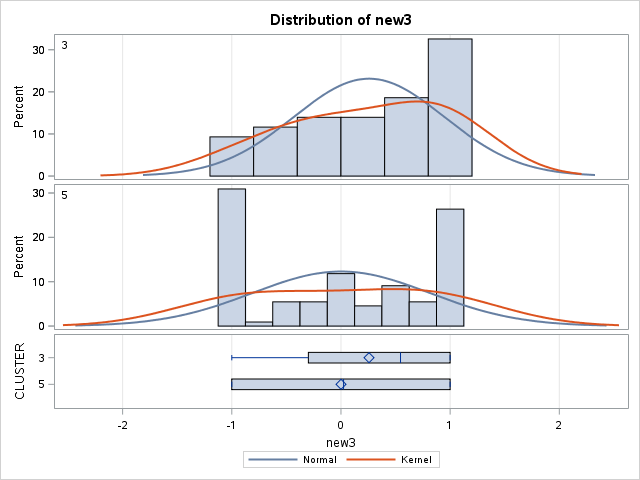
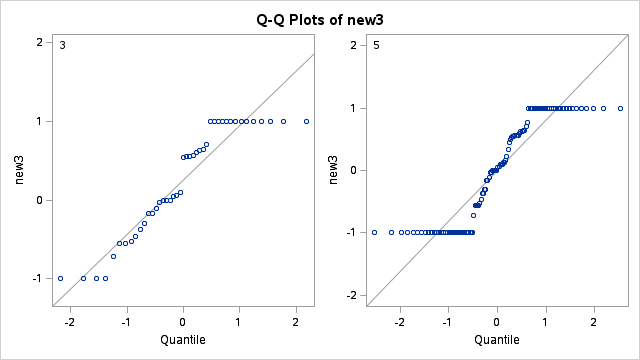
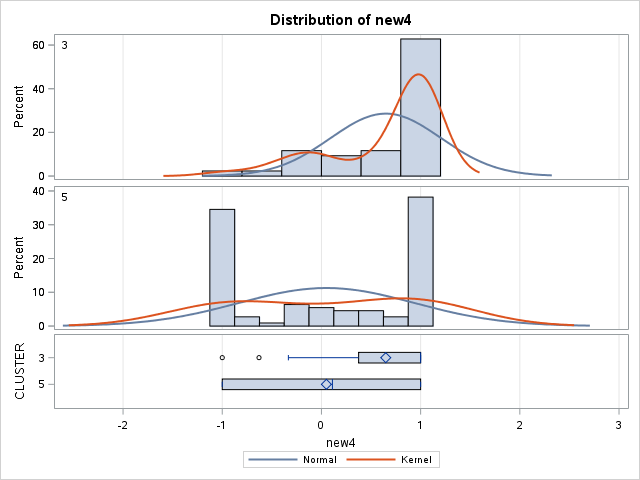
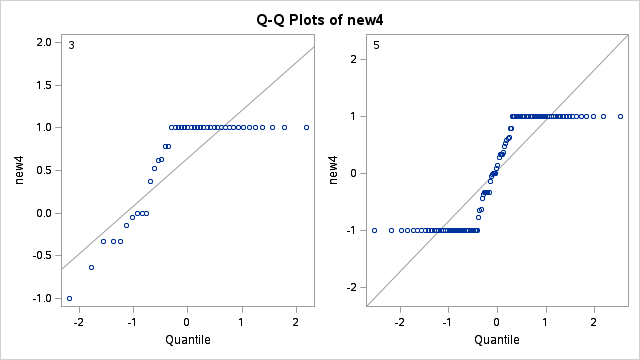
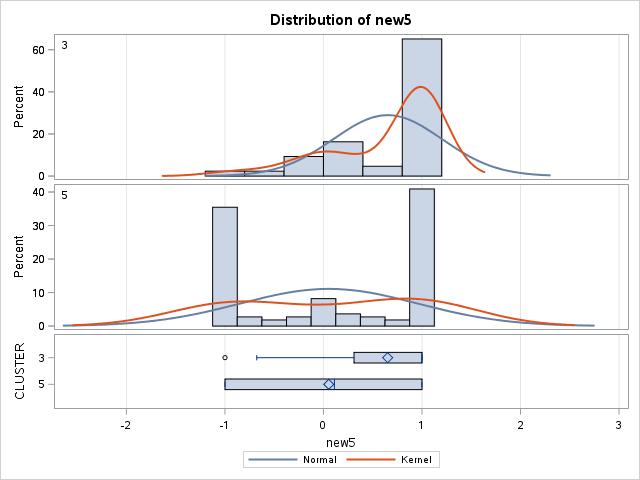
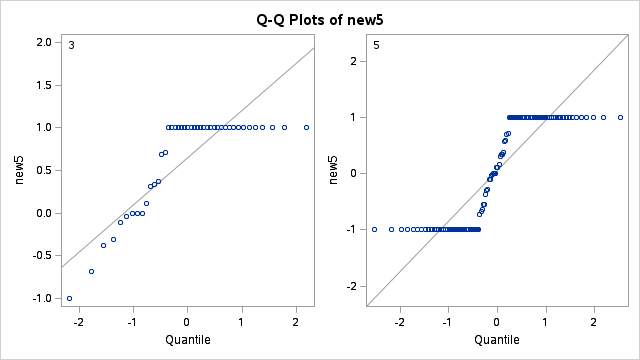
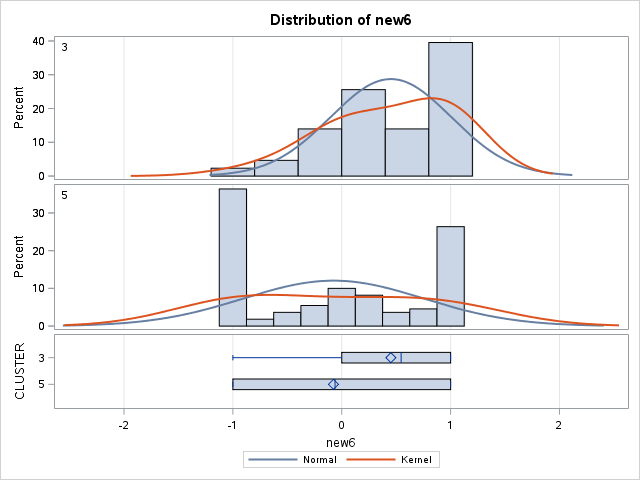
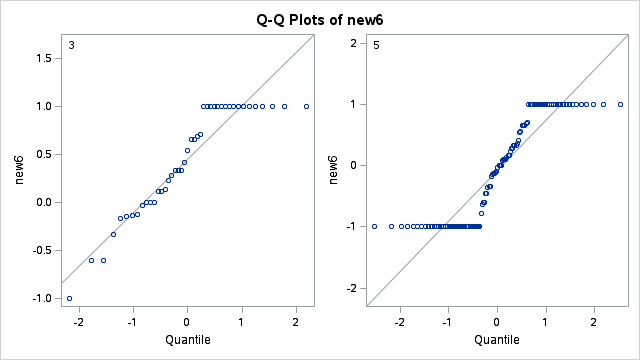
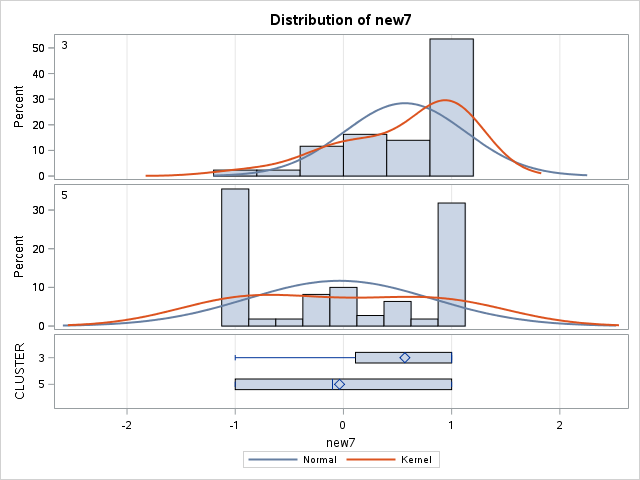
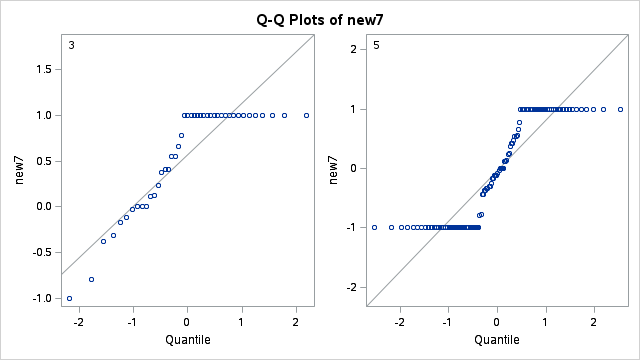
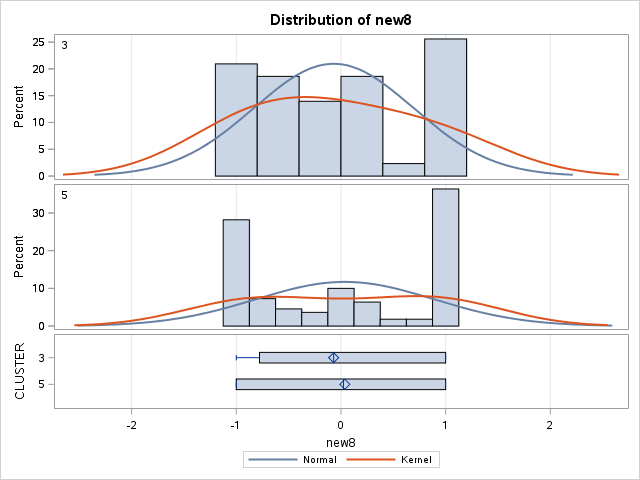
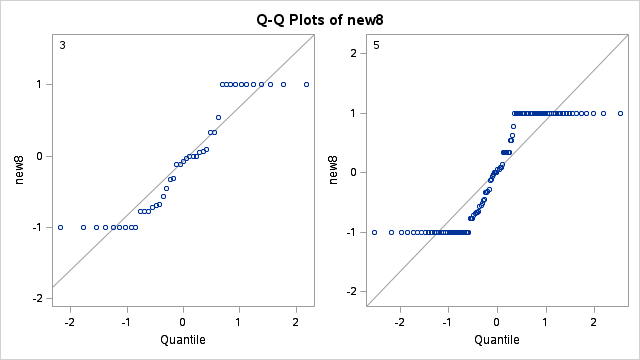
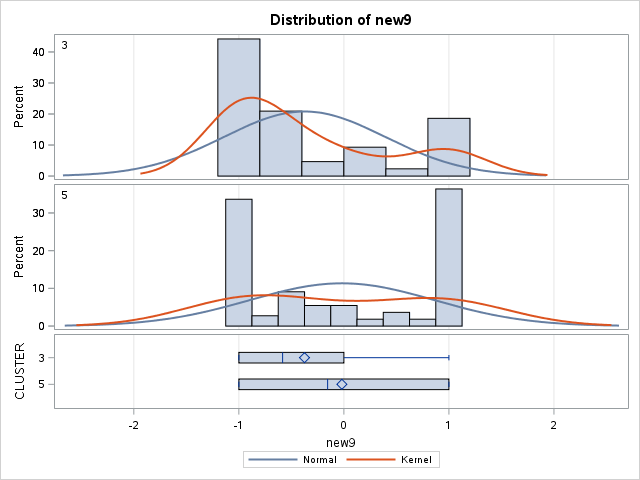
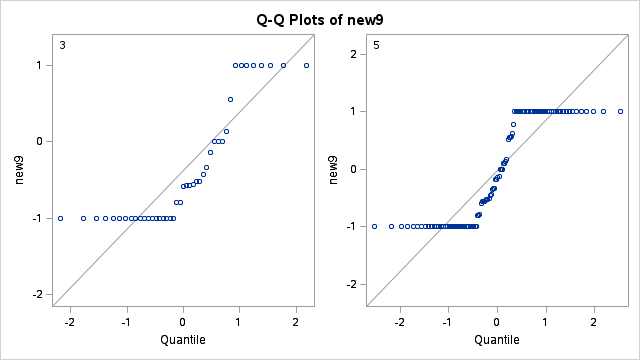
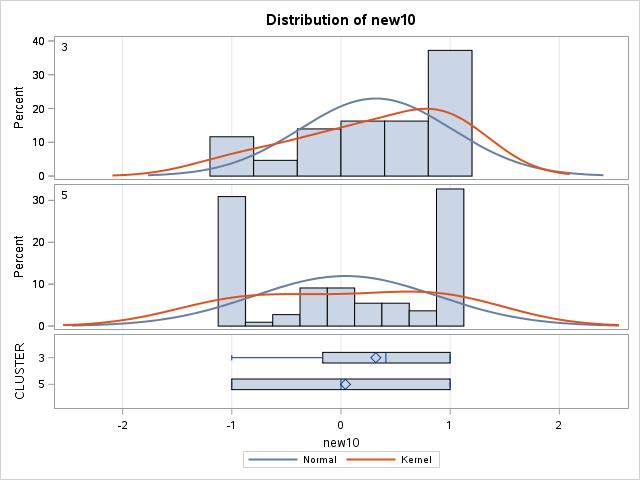
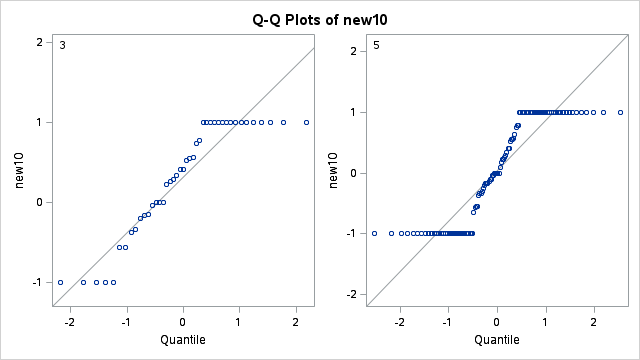

In [21]:
* For cluster 3;
proc ttest data=stat.pop_cluster_data;
var new1-new10;
where cluster=3 or cluster=5;
class cluster;
ods output ttests=stat.ttest_3;
run;

##### Interpretation for Cluster 3
Variables that cannot explain Cluster 3 Individuals
1. Brand
2. CameraQuality
3. Recommendations from Friends and Family
4. Trends
5. Promotions Available

However for individuals in Cluster 3

1. Value for Money , Battery life, OS of a phone and Price is an important characteristic for these individuals
2. Color of a phone is something not considered by individuals of this cluster

****Actual BreakUp****

* Important Variables
* Value For Money  0.6038
* Battery Life  0.5982
* OS  0.5982
* Price  0.5273
* Color -0.4965


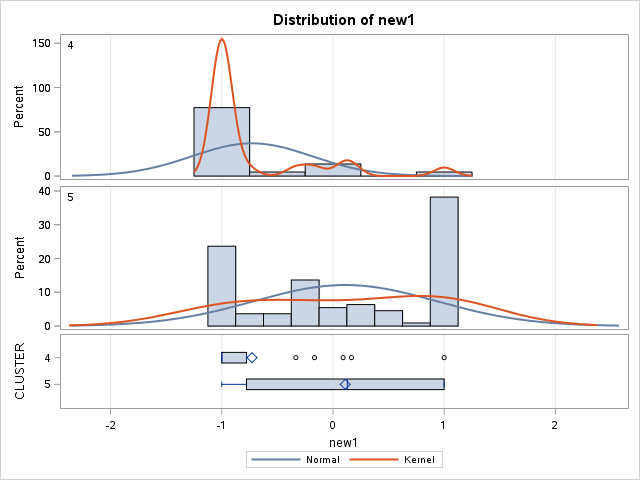
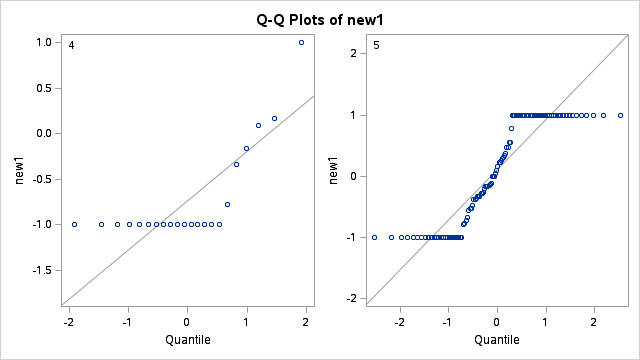
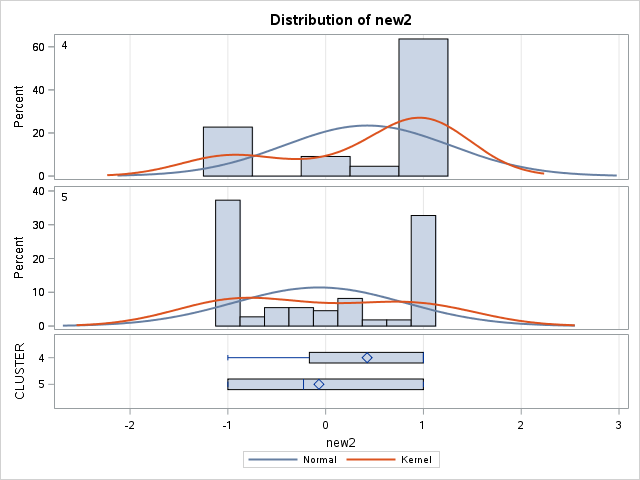
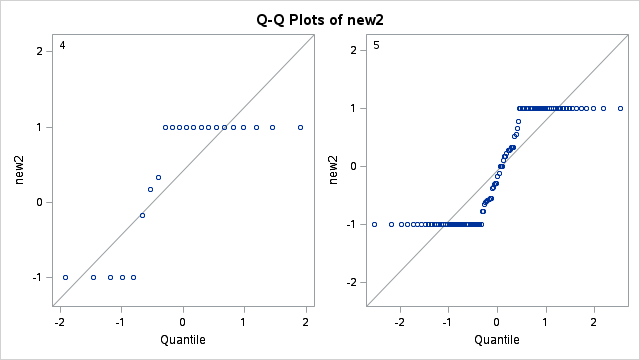
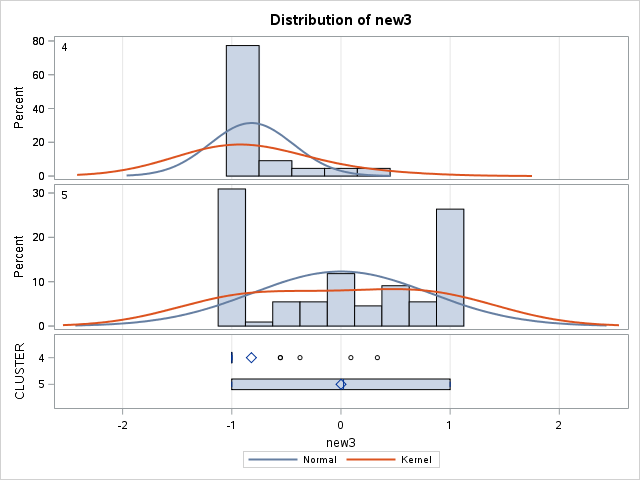
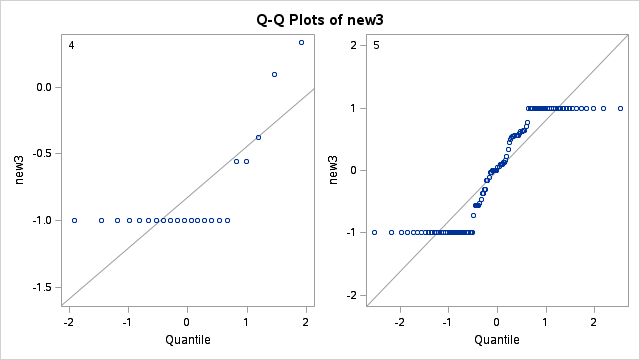
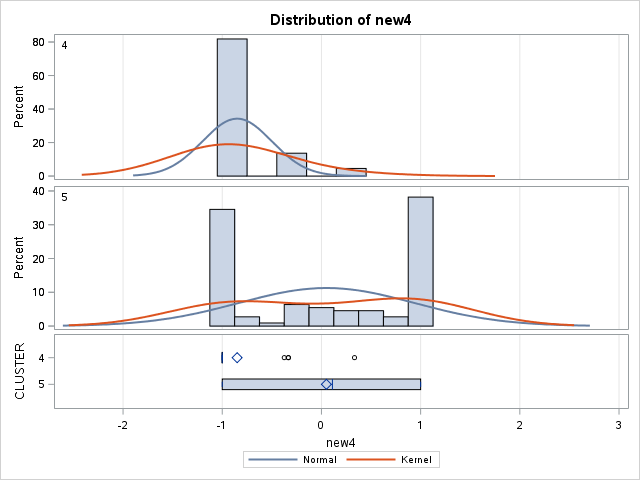
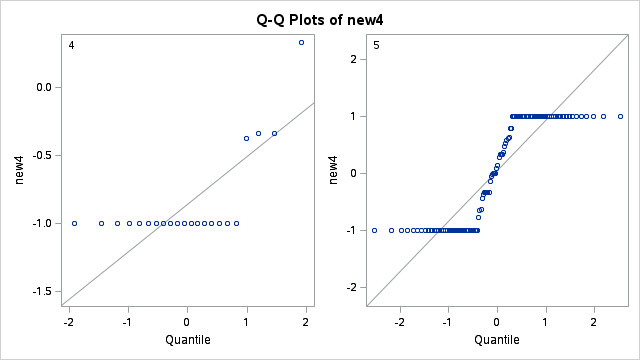
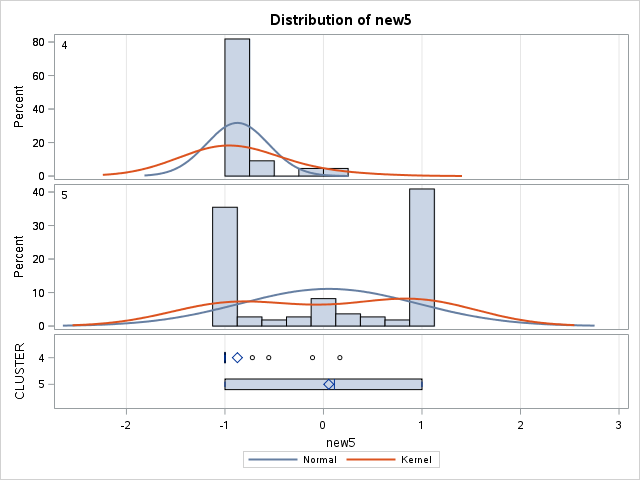
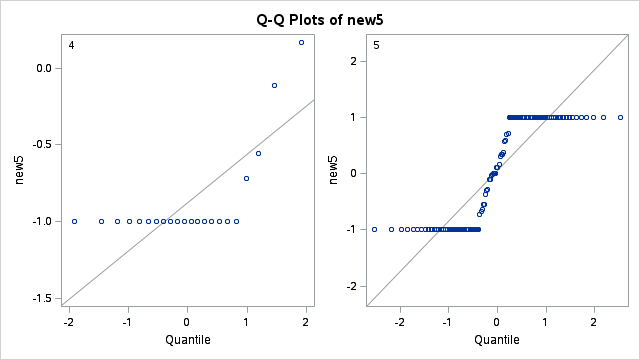
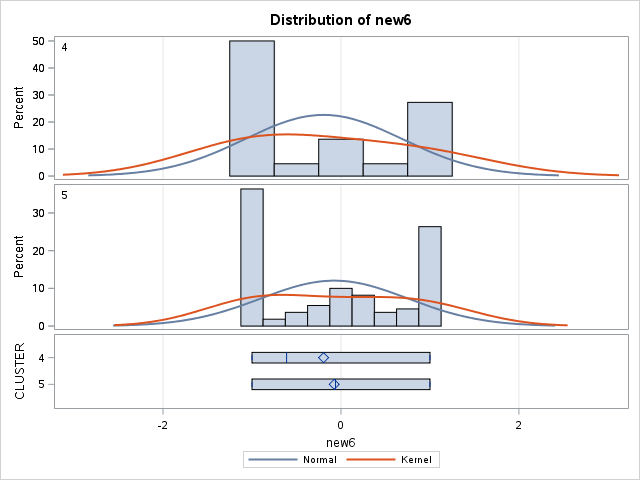
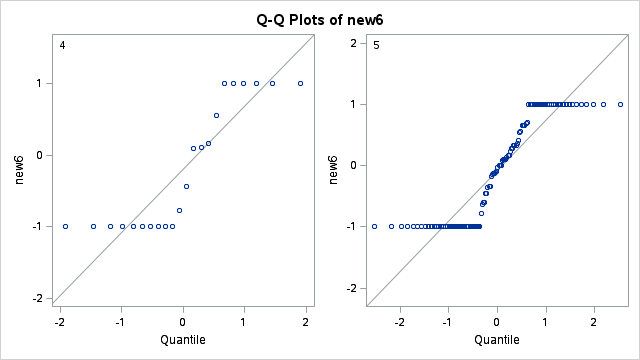
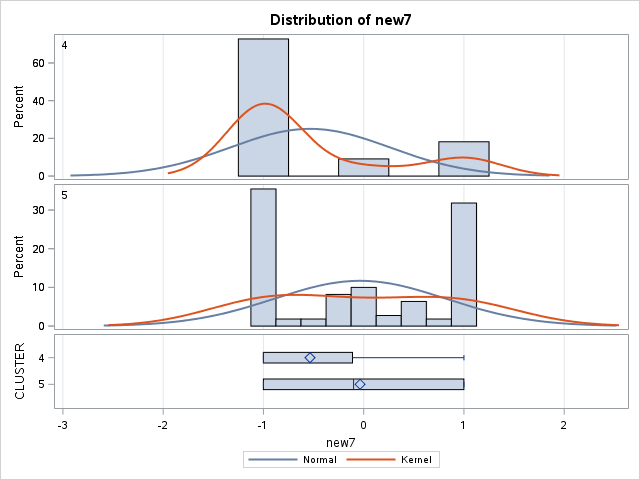
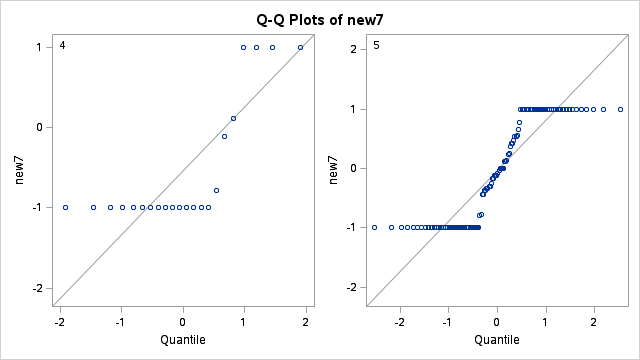
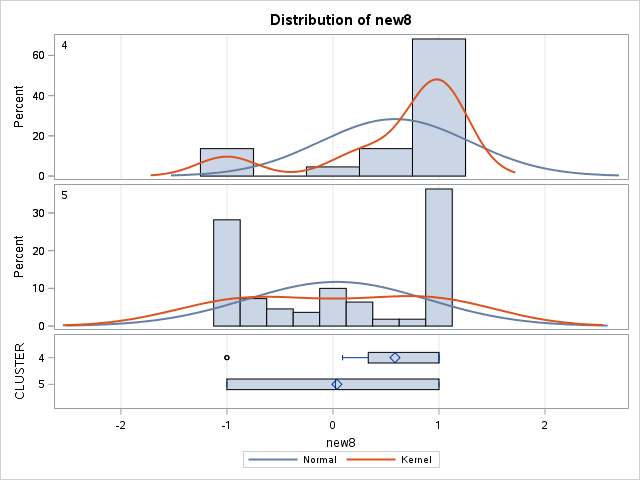
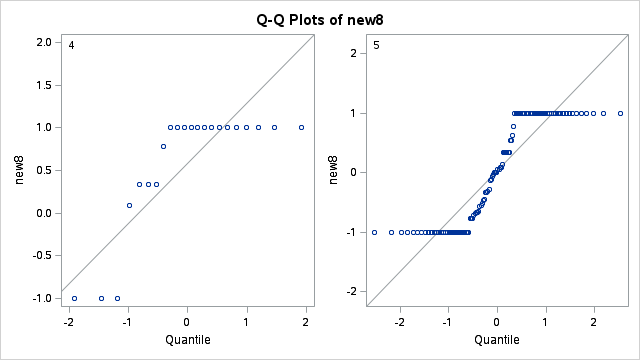
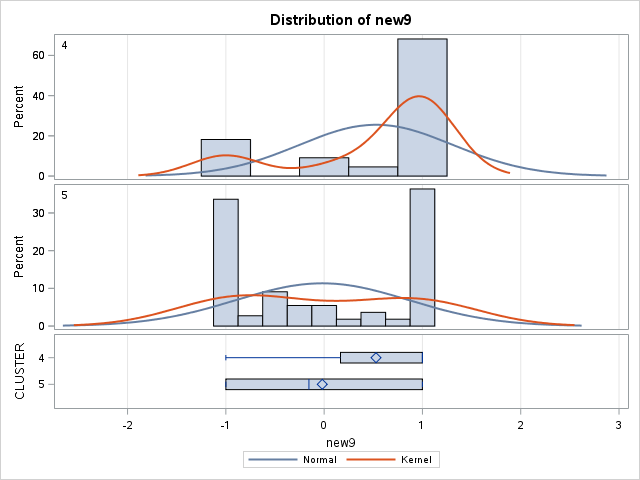
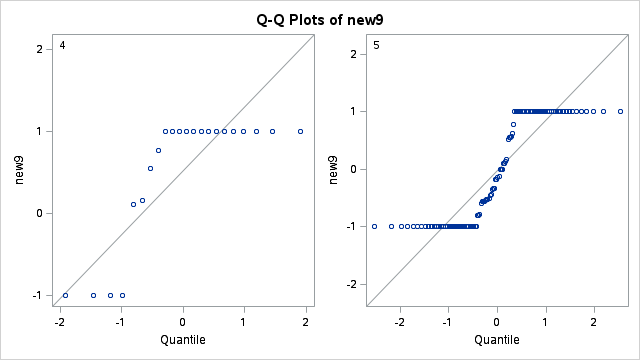
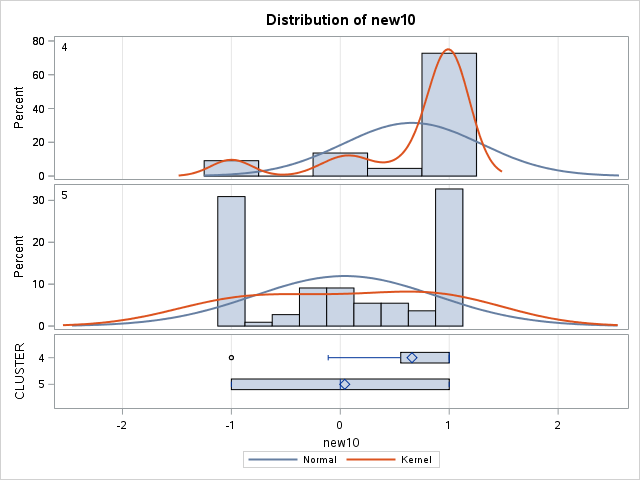
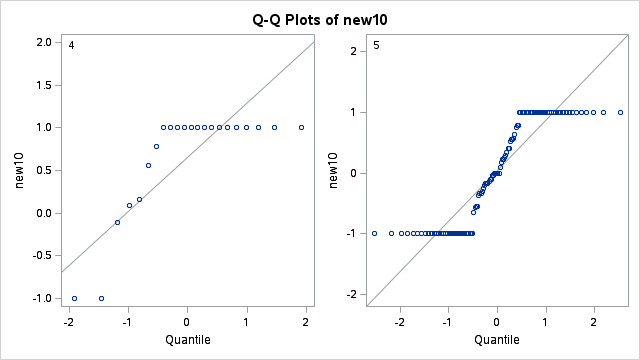

In [22]:
* For cluster 4;
proc ttest data=stat.pop_cluster_data;
var new1-new10;
where cluster=4 or cluster=5;
class cluster;
ods output ttests=stat.ttest_4;
run;

##### Interpretation for Cluster 4
Variables that cannot explain Cluster 4 Individuals
1. Price

However for individuals in Cluster 4

1. Promotions Available, Trends ,Recommendations and color of a phone is an important characteristic for these individuals
2. OS, Battery Life, Brand, Camera Quality , Value for money of a phone is something not considered by individuals of this cluster

****Actual BreakUp****

* Important Variables
* PromotionsAvailable  0.6173
* Recom_Frnd_Fly   0.5483
* Trends   0.5468
* ValueForMoney  -0.4994
* Color    0.4928
* CameraQuality   -0.8211
* Brand   -0.8379
* BatteryLife   -0.9005
* OS  -0.9273

#### To summarise
*Points*
